In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Model
from keras.layers import Dense,  Flatten, Dropout

from keras.applications import VGG16

from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

In [20]:
# définition des paramètres personalisés

# personal layers for VGG16 models
n_classes = 7
n_layers = 2
n_neurons_BeforeLast = 64
f_activation = 'relu'
f_activation_lastLayer = 'softmax'

# personal parameters for compilation
optimizer = 'Adam'
loss = 'categorical_crossentropy'

# personnal parameters for training (fitness)
epochs = 100
batch_size = 32

# personal parameters for datagen
len_heig = 224

#numéro de l'essai
num_essai = '0_VGG16'

In [21]:
# Création du générateur d'images avec augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des valeurs des pixels entre 0 et 1
    rotation_range=10,  # Rotation aléatoire jusqu'à n degrés
    width_shift_range=0,  # Décalage horizontal aléatoire jusqu'à n% de la largeur de l'image
    height_shift_range=0,  # Décalage vertical aléatoire jusqu'à n% de la hauteur de l'image
    shear_range=0.1,  # Cisaillement aléatoire jusqu'à n%
    zoom_range=0.1,  # Zoom aléatoire +/- % de l'échelle originale
    horizontal_flip=True,  # Retournement horizontal aléatoire
    fill_mode='nearest',  # Stratégie de remplissage des nouveaux pixels
    validation_split=0.2  # Split pour validation
)

In [22]:
# Création des générateurs de données d'entraînement et de validation
train_generator = datagen.flow_from_directory(
    '../img_prepa',
    target_size=(len_heig, len_heig),
    batch_size=batch_size,
    class_mode='categorical',  # ou 'binary'
    subset='training',
    shuffle=False
)

Found 4480 images belonging to 7 classes.


In [23]:
validation_generator = datagen.flow_from_directory(
    '../img_prepa',
    target_size=(len_heig, len_heig),
    batch_size=batch_size,
    class_mode='categorical',  # ou 'binary'
    subset='validation',
    shuffle=False
)

Found 1120 images belonging to 7 classes.


In [24]:
# Créer un générateur pour les données de test (reprendre toutes les données du dataset pour vérifier les prédictions)
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    '../img_prepa',  # Chemin vers le répertoire des données de test
    target_size=(224, 224),  # Taille des images (à ajuster selon votre modèle)
    batch_size=batch_size,
    class_mode='categorical',  # ou 'binary' selon votre cas
    shuffle=False  # Ne pas mélanger les données pour correspondre aux étiquettes
)

Found 5600 images belonging to 7 classes.


In [25]:
# Model VGG16 loading without fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [26]:
# Freeze convolution layers to avoid training
for layer in base_model.layers:
    layer.trainable = False

In [27]:
# Add personnal layers for training
x = Flatten()(base_model.output)

for i in range(n_layers):
    x = Dense(n_neurons_BeforeLast * (n_classes-i), activation=f_activation)(x) #personal layer

x = Dropout(0.5)(x)


predictions = Dense(n_classes, activation=f_activation_lastLayer)(x)  # last layer of model for output

In [28]:
# generate model VGG16 with personal fully connected layers
model = Model(inputs=base_model.input, outputs=predictions)

In [29]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [30]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * K.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)


In [31]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [32]:
# model training
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
140/140 [==============================] - 22s 151ms/step - loss: 2.9786 - accuracy: 0.1489 - val_loss: 1.8499 - val_accuracy: 0.2339 - lr: 0.0010
Epoch 2/100
140/140 [==============================] - 21s 148ms/step - loss: 1.9422 - accuracy: 0.1850 - val_loss: 1.9402 - val_accuracy: 0.1545 - lr: 0.0010
Epoch 3/100
140/140 [==============================] - 21s 151ms/step - loss: 1.8607 - accuracy: 0.2223 - val_loss: 1.7493 - val_accuracy: 0.2536 - lr: 0.0010
Epoch 4/100
140/140 [==============================] - 21s 152ms/step - loss: 1.7778 - accuracy: 0.2435 - val_loss: 1.7074 - val_accuracy: 0.2732 - lr: 0.0010
Epoch 5/100
140/140 [==============================] - 21s 148ms/step - loss: 1.7295 - accuracy: 0.2596 - val_loss: 1.6243 - val_accuracy: 0.2688 - lr: 0.0010
Epoch 6/100
140/140 [==============================] - 21s 148ms/step - loss: 1.6800 - accuracy: 0.2701 - val_loss: 1.6441 - val_accuracy: 0.2964 - lr: 0.0010
Epoch 7/100
140/140 [=========================

175/175 [==============================] - 16s 91ms/step


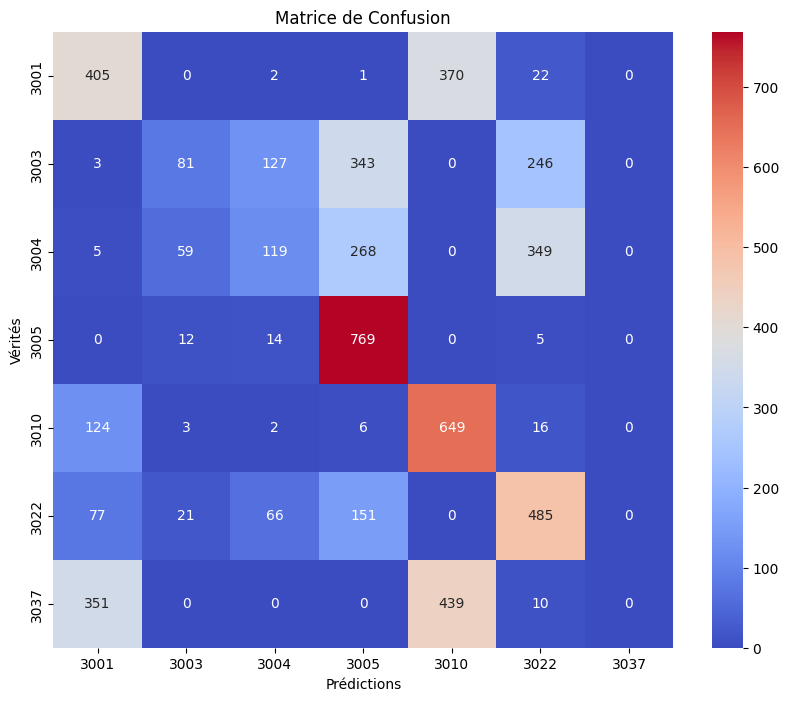

In [33]:
'''
Faire les prédiction sur la gen de test pour établir la matrice de confusion
'''
# Prédire les classes des images de test
predictions = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size)

# Convertir les prédictions en étiquettes
predicted_classes = np.argmax(predictions, axis=1)

# Obtenir les vraies étiquettes des données de test
true_classes = test_generator.classes

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()


In [34]:
# sauvegarde du model
model.save(f"../model_saved/{num_essai}_model.h5py")

INFO:tensorflow:Assets written to: ../model_saved/0_VGG16_model.h5py\assets


INFO:tensorflow:Assets written to: ../model_saved/0_VGG16_model.h5py\assets
